In [428]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import numpy as np
import torch as th

from src.data.comp_2d import GmmRadial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

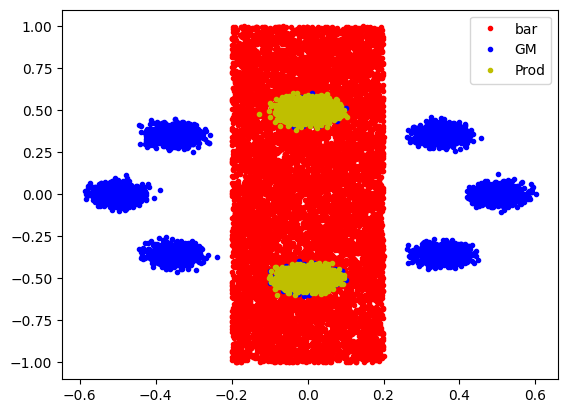

In [427]:
import numpy as np
import torch as th
from src.data.comp_2d import GmmRadial, Bar, sample_from_product
import matplotlib.pyplot as plt

def _sample_from_product(num_samples, gmm, bar):
    """Dumb but correct (ancestral) sampling from product distribution"""
    num_ok_samples = 0
    factor = 4
    while num_ok_samples < num_samples:
        sample, _ = gmm.sample(factor*num_samples)
        in_, out = bar.compute_support(sample)
        num_ok_samples = in_.float().sum()
        factor *=2
    ok_samples = sample[in_]
    return ok_samples[:num_samples]
    

num_samples = 10_000
gmm_data = GmmRadial(8)
gmm_samples, _ = gmm_data.sample(num_samples)
bar_data = Bar()
bar_samples, _ = bar_data.sample(num_samples)

prod_samples = sample_from_product(num_samples, gmm_data, bar_data)
plt.plot(bar_samples[:, 0], bar_samples[:, 1], 'r.', label="bar")
plt.plot(gmm_samples[:, 0], gmm_samples[:, 1], 'b.', label="GM")
plt.plot(prod_samples[:, 0], prod_samples[:, 1], 'y.', label="Prod")
plt.legend()

# Forward process

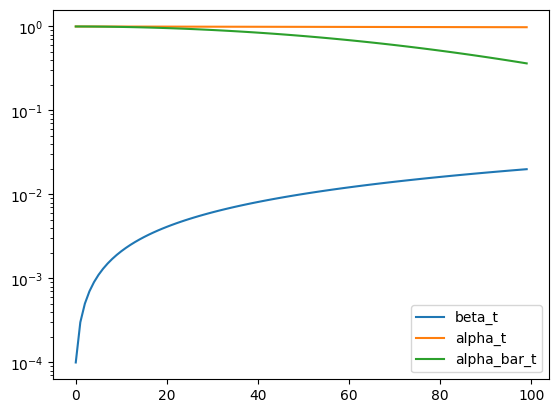

In [3]:
from src.diffusion.base import DiffusionSampler
from src.diffusion.beta_schedules import (
    linear_beta_schedule,
    improved_beta_schedule,
    respaced_beta_schedule,
)
T = 100
betas, time_steps = respaced_beta_schedule(
    original_betas=linear_beta_schedule(num_timesteps=T),
    # original_betas=improved_beta_schedule(num_timesteps=T),
    T=T,
    respaced_T=T,
)
# betas[-1] = betas[-2]
diff_proc = DiffusionSampler(betas, time_steps, posterior_variance="beta")
_, ax = plt.subplots()
ax.semilogy(time_steps, diff_proc.betas, label="beta_t")
ax.semilogy(time_steps, diff_proc.alphas, label="alpha_t")
ax.semilogy(time_steps, diff_proc.alphas_bar, label="alpha_bar_t")
ax.legend();

In [4]:
from src.comp.base import ProductCompSampler, reverse_func_prod
from src.utils.net import get_device, Device
from exp.comp_2d.prod_comp_sample import load_diff_model
t = 99
ts = t * th.ones((prod_samples.size(0),), dtype=th.long)
noise = th.randn_like(prod_samples)
x_t_forward = diff_proc.q_sample(prod_samples, ts, noise)
comp = th.randn_like(prod_samples)


device = get_device(Device.GPU)
models_dir = Path.cwd().parent / "models/comp_two_d"
diff_model_gmm = load_diff_model(models_dir / "gmm.pt", T, device)
diff_model_bar = load_diff_model(models_dir / "bar.pt", T, device)
# diff_proc = DiffusionSampler(betas, time_steps, posterior_variance="beta")
prod_sampler = ProductCompSampler(diff_model_gmm, diff_model_bar, diff_proc, use_reverse_step=True)

num_samples = 1000
x_t = comp[num_samples:].to(device)
x_t = x_t_forward[num_samples:].to(device)
x_tm1 = reverse_func_prod(prod_sampler, t=th.tensor(t), t_idx=t, x_tm1=x_t, device=device).cpu()
# prod_samples, _ = prod_sampler.sample(2, device, th.Size((2,)), verbose=True)

_, (ax_t, ax_s) = plt.subplots(1, 2, figsize=(12, 6))
ax_t.plot(comp[:, 0], comp[:, 1], '.', label="N(0, I)")
ax_t.plot(x_t_forward[:, 0], x_t_forward[:, 1], '.', label=f"q(x_{t} | x_0)")
ax_t.set_title(f"t={t}")
ax_t.legend();

ax_s.plot(x_tm1[:, 0], x_tm1[:, 1], '.', label=f"p(x_{t-1} | x_{t})")
ax_s.set_title(f"t={t-1}")
ax_s.legend();
diff_proc.alphas_bar[-1]

ModuleNotFoundError: No module named 'exp.comp_2d'

tensor(204.9484, device='cuda:0')
mean norm:  tensor(98.6364, device='cuda:0')


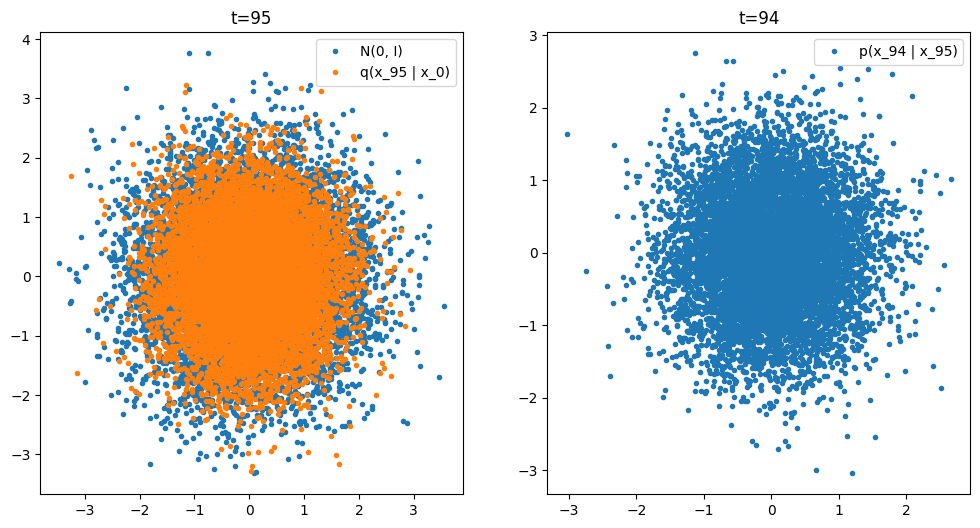

In [285]:
num_samples = 1000

x_t = reverse_func_prod(prod_sampler, t=th.tensor(t), t_idx=t, x_tm1=x_t, device=device)
t -= 1
# prod_samples, _ = prod_sampler.sample(2, device, th.Size((2,)), verbose=True)

_, (ax_t, ax_s) = plt.subplots(1, 2, figsize=(12, 6))
ax_t.plot(comp[:, 0], comp[:, 1], '.', label="N(0, I)")
ax_t.plot(x_t_forward[:, 0], x_t_forward[:, 1], '.', label=f"q(x_{t} | x_0)")
ax_t.set_title(f"t={t}")
ax_t.legend();

aba = x_t.clone().detach().cpu()
ax_s.plot(aba[:, 0], aba[:, 1], '.', label=f"p(x_{t-1} | x_{t})")
ax_s.set_title(f"t={t-1}")
ax_s.legend();

# Product composition

Given two unconditional score-parameterised diffusion models:
$$
\epsilon_\theta^{GMM}(x_t, t),\quad \epsilon_\theta^{Bar}(x_t, t)
$$
Trained separately on the two datasets above respectively.
Below are samples drawn from the reverse process of each model.

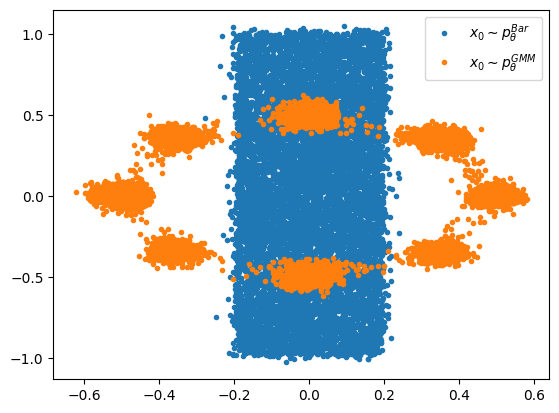

In [70]:
from pathlib import Path
import matplotlib.pyplot as plt
bar_xs = th.load(Path.cwd().parent / "results/comp_2d/bar_samples.th")
gmm_xs = th.load(Path.cwd().parent / "results/comp_2d/gmm_samples.th")

plt.plot(bar_xs[:, 0], bar_xs[:, 1], '.', label="$x_0 \sim p_\\theta^{Bar}$")
plt.plot(gmm_xs[:, 0], gmm_xs[:, 1], '.', label="$x_0 \sim p_\\theta^{GMM}$")
plt.legend()

## Sampling from product composition
To sample from the composed model, we compose a score
$$
\nabla_{x_t} \log p_\theta^{prod} = - \frac{1}{\sigma_t} \left( \epsilon_\theta^{GMM}(x_t, t) + \epsilon_\theta^{Bar}(x_t, t) \right).
$$

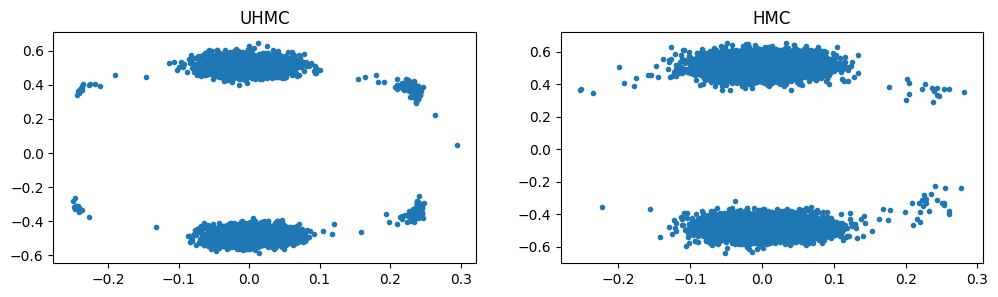

In [434]:
from pathlib import Path
import matplotlib.pyplot as plt

dir_ = Path.cwd().parent / "results/comp_2d/"

methods = [
    "rev",
    "ula",
    "la",
    "uhmc",
    "hmc"
]
methods = list(filter(lambda m: (dir_ / f"score_{m}_0").exists(), methods))
_, (axes) = plt.subplots(1, len(methods), figsize=(12,3))

for method, ax in zip(methods, axes):
    sample = th.load(dir_ / f"score_{method}_0" / "prod_samples.th")
    ax.plot(sample[:, 0], sample[:, 1], '.')
    ax.set_title(method.upper())

# Alphas

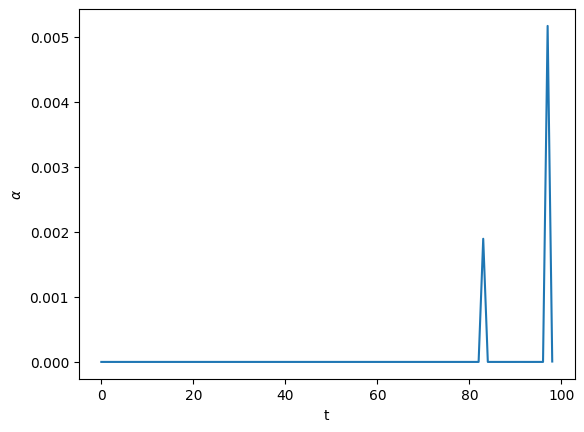

In [39]:
import pickle
from exp.comp_two_d.utils import SimulationConfig
def print_setup(dir_):
    config = SimulationConfig.from_json(dir_ / "config.json")
    steps = config.mcmc_stepsizes
    print(f"MCMC:\t\t {config.mcmc_method.upper()}({config.mcmc_steps}), MCMC stop t<={config.mcmc_lower_t if config.mcmc_lower_t is not None else 0}")
    print(f"Steps:\t\t {steps['beta_schedule']} betas: {steps['params']['factor']}*beta_t^{steps['params']['exponent']}")
    print(f"Guidance:\t lambda={config.guid_scale}")
    print(f"Energy:\t\t num trapez={config.n_trapets}")
    # f"MCMC stop t<={config.mcmc_lower_t}, Method: {config.mcmc_method}({config.mcmc_steps}), lambda={config.guid_scale}, n_trapets: {config.n_trapets}, a={factor}, b={exp}, steps={bs}"

def parse_alphas(alphas, num_mcmc_steps):
    alphas_t = []
    count = 0
    for t, as_ in alphas.items():
        avg_a = 0.0
        for as_batch in as_:
            as_batch[as_batch > 1.0] = 1.0
            tmp = as_batch[as_batch < 1.0]
            count += len(tmp[tmp > 0.1])
            avg_a += as_batch.mean().item()
        # print(f"t={t}, mean alpha={avg_a / num_mcmc_steps}")
        alphas_t.append(avg_a / num_mcmc_steps)
    # print(count)
    return th.tensor(alphas_t)
    

def parse_accepts(all_accepts, num_mcmc_steps):
    avg_accept_t = []
    for t, accs in all_accepts.items():
        # print(f"t={t}")
        tau_str = ""
        tmp = 0.0
        for tau, acc_batch in enumerate(accs):
            avg_accept = acc_batch.mean().item()
            # print(avg_accept)
            tmp += avg_accept
            tau_str += f"tau={tau+1}: {avg_accept*100}% "
        avg_accept_t.append(tmp / num_mcmc_steps)
        # print(f"\t {tau_str}")
    return th.tensor(avg_accept_t)

dir_ = Path.cwd().parent / "results/comp_2d/score_la_0/"
with open(dir_ / f"alphas_.p", "rb") as ff:
    alphas = pickle.load(ff)
with open(dir_ / f"energy_diff_.p", "rb") as ff:
    energy_diff = pickle.load(ff)
with open(dir_ / f"all_accepts_.p", "rb") as ff:
    all_accepts = pickle.load(ff)

num_mcmc_steps = len(all_accepts[0])
avg_alphas_t = parse_alphas(alphas, num_mcmc_steps)
avg_accept_t = parse_accepts(all_accepts, num_mcmc_steps)

ts = list(all_accepts.keys())
_, ax_alphas = plt.subplots()

ax_alphas.plot(ts, avg_alphas_t)
ax_alphas.set_xlabel("t")
ax_alphas.set_ylabel("$\\alpha$");

In [404]:
from functools import partial
from torch.distributions.multivariate_normal import MultivariateNormal
from src.comp.base import ProductCompSampler

import numpy as np
class Ebm():
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        self.inv = th.diagflat(1 / th.diag(cov))
        
    def energy(self, x):
        diff = x - self.mean
        return diff.T @ self.inv @ diff / 2

    def grad_energy(self, x):
        diff = x - self.mean
        return self.inv @ diff / 2

    def log_prob(self, x):
        log_norm = np.log(2) + np.log(np.pi) + th.log(th.diag(cov).prod())
        return - log_norm - self.energy(x)
        
    def score(self, x):
        return - self.grad_energy(x)


def estimate_energy_diff_linear(gradient_function, x, x_hat, t, t_idx, ss_, classes, dims):
    diff = x_hat - x
    x_ = x + ss_[0] * diff
    e = (gradient_function(x_, t, t_idx, classes) * diff).sum(dim=tuple(range(1, dims))).reshape(-1, 1)
    for j in range(1, len(ss_)):
        x_ = x + ss_[j] * diff
        e = th.cat(
            (e, (gradient_function(x_, t, t_idx, classes) * diff).sum(dim=tuple(range(1, dims))).reshape(-1, 1)), 1
        )
    return th.trapz(e, ss_)

def gradient_function(x, t, t_idx, classes, ebm):
    return ebm.score(x)

def langevin_step(x, t, t_idx, classes, step_sizes, gradient_function):
    ss = step_sizes[t]
    std = (2 * ss) ** 0.5
    mean_x = get_mean(gradient_function, x, t, t_idx, ss, classes)
    noise = th.randn_like(x) * std
    x_hat = mean_x + noise
    return x_hat, mean_x, ss

def get_mean(gradient_function, x, t, t_idx, ss, classes):
    """Get mean of transition distribution"""
    grad = gradient_function(x, t, t_idx, classes)
    return x + grad * ss

x = th.tensor([-1., -1.])
mean = th.zeros((2,))
cov = th.eye(2)
ebm = Ebm(mean, cov)
distr_ = MultivariateNormal(loc=mean, covariance_matrix=cov)
x_hat = th.zeros_like(x)
grad_fn = partial(gradient_function, ebm=ebm)
grad_fn(x, None, None, None)
xs = []
x_tau = x
n_trapets = 5
ss = th.linspace(0, 1, steps=n_trapets)

est_delta_e = estimate_energy_diff_linear(grad_fn, x, x_hat, 0, 0, ss, None, dims = x.dim())
true_delta_e = ebm.log_prob(x_hat) - ebm.log_prob(x)
est_delta_e, true_delta_e

(tensor([0.5000]), tensor(1.))

tensor([0.5000, 0.5000])

In [118]:
for t, tau in enumerate(range(100)):
    x_tau, _, ss = langevin_step(x_tau, t, t, None, [0.001*0.99**t for t in range(100)], grad_fn)
    xs.append(x_tau.clone())
xs = th.stack(xs)
plt.plot(x[0], x[1], 'rx')
plt.plot(mean[0], mean[1], 'gx')
plt.plot(xs[:, 0], xs[:, 1], '.-')

tensor([-0.5000, -0.5000])

In [328]:
th.linalg.det(cov)

tensor(1.)

# Classifier-free guidance on 2D GMM

We denote the components in the GMM with a respective class. We train a classifier $p(y \mid x_t, t)$ and perform guided sampling. 

In [166]:
import numpy as np
import torch as th
from src.data.comp_2d import GmmRadial, Bar
import matplotlib.pyplot as plt
from src.model.comp_2d.classifier import Classifier, load_classifier
from src.utils.metrics import accuracy, hard_label_from_logit

num_samples = 10_000
T = 100
gmm_data = GmmRadial(8)
gmm_samples, labels = gmm_data.sample(num_samples)

params = Path.cwd().parent / "models/comp_2d/class_t_gmm.pt"
class_ = load_classifier(params, gmm_data.num_comp, "cpu")
t = th.ones((num_samples,)).long()
logits = class_(gmm_samples, t)
acc = accuracy(hard_label_from_logit(logits), labels)
print(f"Accuracy at t=0: {acc * 100:.2f}%")

Accuracy at t=0: 100.00%


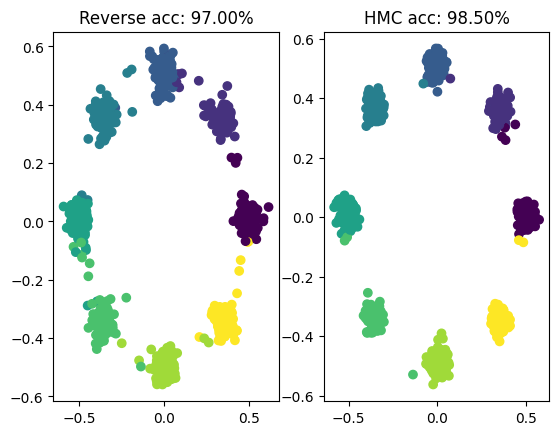

In [168]:
from torch.distributions.multivariate_normal import MultivariateNormal

def conditional_nll(gmm, samples, classes):
    cov = gmm.std**2 * th.eye(2)
    ll = 0.0
    for cl in th.arange(classes.max() + 1):
        mean = gmm.means[cl]
        cond_samples = samples[classes == cl, :]
        pdf = MultivariateNormal(loc=mean, covariance_matrix=cov)
        ll += pdf.log_prob(cond_samples).sum().item()
    num_samples = classes.size(0)
    return -ll / num_samples
    
res_dir = Path.cwd().parent / "results/comp_2d"
classes = th.load(res_dir / "guid_classes_gmm.th")
guid_samples = th.load(res_dir / "guid_samples_gmm.th")
hmc_guid_samples = th.load(res_dir / "hmc_guid_samples_gmm.th")
classes_hmc = th.load(res_dir / "hmc_guid_classes_gmm.th")

assert th.allclose(classes, classes_hmc)
# Classification accuracy
t = th.ones((classes.size(0),)).long()
logits = class_(guid_samples, t)
labels_rev = hard_label_from_logit(logits)
acc_rev = accuracy(labels_rev, classes)
logits = class_(hmc_guid_samples, t)
labels_hmc = hard_label_from_logit(logits)
acc_hmc = accuracy(labels_hmc, classes)

# Sampling NLL
marginal_nll_rev = gmm_data.nll(guid_samples)
marginal_nll_hmc = gmm_data.nll(hmc_guid_samples)
cond_nll_rev = gmm_data.conditional_nll(guid_samples, classes)
cond_nll_hmc = gmm_data.conditional_nll(hmc_guid_samples, classes)

_, [ax_guid, ax_hmc] = plt.subplots(1, 2)
ax_guid.scatter(guid_samples[:, 0], guid_samples[:, 1], c=classes)
ax_guid.set_title(f"Reverse acc: {acc_rev * 100:.2f}%")
ax_hmc.scatter(hmc_guid_samples[:, 0], hmc_guid_samples[:, 1], c=classes)
ax_hmc.set_title(f"HMC acc: {acc_hmc * 100:.2f}%");

# error_inds = classes == labels_rev
# _, [ax_guid, ax_hmc] = plt.subplots(1, 2)
# ax_guid.scatter(guid_samples[:, 0], guid_samples[:, 1], c=error_inds)
# ax_guid.set_title(f"Reverse acc: {acc_rev * 100:.2f}%")
# error_inds = classes == labels_hmc
# ax_hmc.scatter(hmc_guid_samples[:, 0], hmc_guid_samples[:, 1], c=error_inds)
# ax_hmc.set_title(f"HMC acc: {acc_hmc * 100:.2f}%");

#print(f"Reverse:\n\t Acc: {acc_rev*100:.2f}%\t Marginal NLL: {marginal_nll_rev:.4f}\t Cond. NLL: {cond_nll_rev:.4f}")
#print(f"HMC:\n\t Acc: {acc_hmc*100:.2f}%\t Marginal NLL: {marginal_nll_hmc:.4f}\t Cond. NLL: {cond_nll_hmc:.4f}")

# Metrics

NB: Only one simulation (1000 samples)
|            | Acc. [%] | Cond. NLL | Marg. NLL |
|------------|----------|-------------|-----------|
| Reverse    | 97.0     | -2.5835     | -1.6685   |
| HMC        | 98.5     | -3.5724     | -2.2974   |

ModuleNotFoundError: No module named 'jax'